In [52]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xmitgcm import open_mdsdataset
from xgcm import Grid
%matplotlib inline

In [48]:
from xgcm.autogenerate import generate_grid_ds


dimXList = ['lon', 'longitude', 'LON', 'LONGITUDE', 'geolon', 'GEOLON',
            'xt_ocean']
dimYList = ['lat', 'latitude' , 'LAT', 'LATITUDE' , 'geolat', 'GEOLAT',
            'yt_ocean']


def add_MITgcm_missing_metrics(dset, periodic=None, boundary=None):
    """
    Infer missing metrics from MITgcm output files.

    Parameters
    ----------
    dset : xarray.Dataset
        A dataset open from a file
    periodic : str
        Which coordinate is periodic
    boundary : dict
        Default boundary conditions applied to each coordinate

    Return
    -------
    dset : xarray.Dataset
        Input dataset with appropriated metrics added
    grid : xgcm.Grid
        The grid with appropriated metrics
    """
    coords = dset.coords
    grid   = Grid(dset, periodic=periodic, boundary=boundary)
    
    if 'drW' not in coords: # vertical cell size at u point
        coords['drW'] = dset.hFacW * dset.drF
    if 'drS' not in coords: # vertical cell size at v point
        coords['drS'] = dset.hFacS * dset.drF
    if 'drC' not in coords: # vertical cell size at tracer point
        coords['drC'] = dset.hFacC * dset.drF
    if 'drG' not in coords: # vertical cell size at tracer point
        coords['drG'] = dset.Zl - dset.Zl + dset.drC.values[:-1]
        # coords['drG'] = xr.DataArray(dset.drC[:-1].values, dims='Zl',
        #                              coords={'Zl':dset.Zl.values})
    
    if 'dxF' not in coords:
        coords['dxF'] = grid.interp(dset.dxC, 'X')
    if 'dyF' not in coords:
        coords['dyF'] = grid.interp(dset.dyC, 'Y')
    if 'dxV' not in coords:
        coords['dxV'] = grid.interp(dset.dxG, 'X')
    if 'dyU' not in coords:
        coords['dyU'] = grid.interp(dset.dyG, 'Y')
    
    if 'hFacZ' not in coords:
        coords['hFacZ'] = grid.interp(dset.hFacS, 'X')
    if 'maskZ' not in coords:
        coords['maskZ'] = coords['hFacZ']
        
    if 'yA' not in coords:
        coords['yA'] = dset.drF * dset.hFacC * dset.dxF
    
    # Calculate vertical distances located on the cellboundary
    # ds.coords['dzC'] = grid.diff(ds.depth, 'Z', boundary='extrapolate')
    # Calculate vertical distances located on the cellcenter
    # ds.coords['dzT'] = grid.diff(ds.depth_left, 'Z', boundary='extrapolate')
    
    metrics = {
        ('X',)    : ['dxG', 'dxF', 'dxC', 'dxV'], # X distances
        ('Y',)    : ['dyG', 'dyF', 'dyC', 'dyU'], # Y distances
        ('Z',)    : ['drW', 'drS', 'drC', 'drF', 'drG'], # Z distances
        ('X', 'Y'): ['rAw', 'rAs', 'rA' , 'rAz'], # Areas in X-Y plane
        ('X', 'Z'): ['yA']} # Areas in X-Z plane
    
    grid._assign_metrics(metrics)
    
    return dset, grid

In [2]:
path = '/data/home/liutongya/RCLV/velocity/run_offline/run/'
ds = open_mdsdataset(path, prefix={'Diag_stat'}).chunk()
ds

<xarray.Dataset>
Dimensions:  (XC: 3600, XG: 3600, YC: 1600, YG: 1600, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 9859)
Coordinates:
  * XC       (XC) >f4 0.05 0.15 0.25 0.35 0.45 ... 359.65 359.75 359.85 359.95
  * YC       (YC) >f4 -79.95 -79.85 -79.75 -79.65 ... 79.65 79.75 79.85 79.95
  * XG       (XG) >f4 -2.7755576e-17 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * YG       (YG) >f4 -80.0 -79.9 -79.8 -79.7 -79.6 ... 79.5 79.6 79.7 79.8 79.9
  * Z        (Z) >f4 -50.0
  * Zp1      (Zp1) >f4 0.0 -100.0
  * Zu       (Zu) >f4 -100.0
  * Zl       (Zl) >f4 0.0
    rA       (YC, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(2,), meta=np.ndarray>
    hFacC    (YC, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    hFacW    (YC, XG) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    hFacS    (YG, XC) >f4 dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    maskC    (YC, XC) bool dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    maskW    (YC, XG) bool dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    maskS    (YG, XC) bool dask.array<chunksize=(1600, 3600), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(1,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 00:00:01 00:00:02 ... 02:44:18 02:44:19
Data variables:
    UVEL     (time, YC, XG) float32 dask.array<chunksize=(1, 1600, 3600), meta=np.ndarray>
    VVEL     (time, YG, XC) float32 dask.array<chunksize=(1, 1600, 3600), meta=np.ndarray>
    PhiVEL   (time, YC, XC) float32 dask.array<chunksize=(1, 1600, 3600), meta=np.ndarray>
    PsiVEL   (time, YG, XG) float32 dask.array<chunksize=(1, 1600, 3600), meta=np.ndarray>

In [186]:
ds, grid = add_MITgcm_missing_metrics(ds, periodic='X', boundary={'Y':'extend'})

## ori vel

In [187]:
path_ori = '/data/home/liutongya/RCLV/velocity/vel_ori/'

num = 1350

ufn = path_ori + 'uvel.' + str(num).zfill(10) + '.data'
vfn = path_ori + 'vvel.' + str(num).zfill(10) + '.data'

uvel_ori = np.fromfile(ufn, dtype='>f4').reshape(1600, 3600)
vvel_ori = np.fromfile(vfn, dtype='>f4').reshape(1600, 3600)

In [192]:
uu0 = xr.DataArray(uvel_ori, coords={'YC':ds.YC, 'XG': ds.XG}, dims=['YC', 'XG'])
uu0 = uu0.where(uu0!=0)

In [193]:
vv0 = xr.DataArray(vvel_ori, coords={'YG':ds.YG, 'XC': ds.XC}, dims=['YG', 'XC'])
vv0 = vv0.where(vv0!=0)

In [199]:
dudx0 = grid.derivative(uu0, 'X')
dvdy0 = grid.derivative(vv0, 'Y')

## corr vel

In [214]:
path_corr = '/data/home/liutongya/RCLV/velocity/vel_corr/'

num = 1350 #random day

ufn = path_corr + 'uvel.' + str(num).zfill(10) + '.data'
vfn = path_corr + 'vvel.' + str(num).zfill(10) + '.data'

uvel_corr = np.fromfile(ufn, dtype='>f4').reshape(1600, 3600)
vvel_corr = np.fromfile(vfn, dtype='>f4').reshape(1600, 3600)

In [215]:
uu1 = xr.DataArray(uvel_corr, coords={'YC':ds.YC, 'XG': ds.XG}, dims=['YC', 'XG'])
uu1 = uu1.where(uu1!=0)

In [216]:
vv1 = xr.DataArray(vvel_corr, coords={'YG':ds.YG, 'XC': ds.XC}, dims=['YG', 'XC'])
vv1 = vv1.where(vv1!=0)

In [217]:
dudx1 = grid.derivative(uu1, 'X')
dvdy1 = grid.derivative(vv1, 'Y')

(-1e-06, 1e-06)

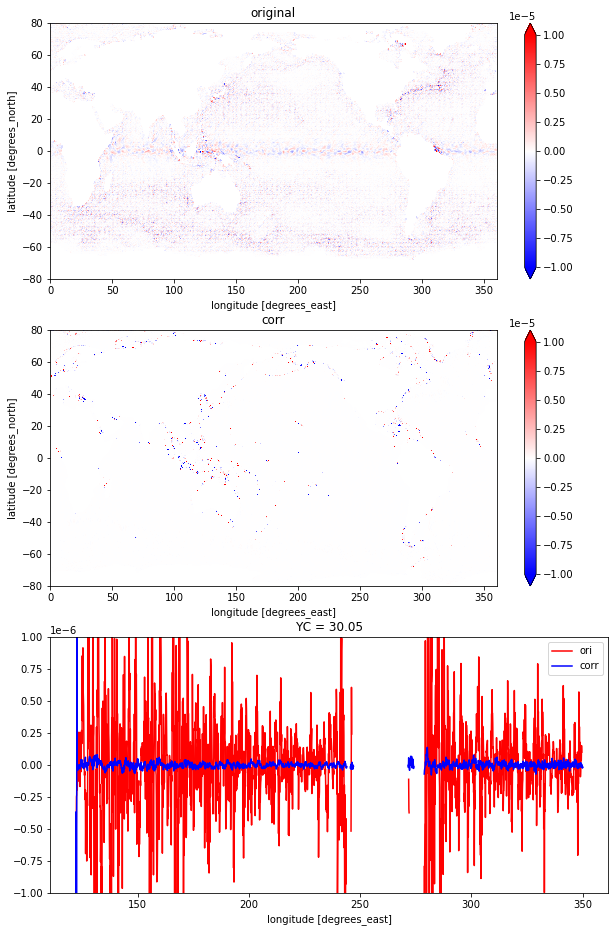

In [222]:
fig = plt.figure(figsize=(10, 16))

plt.subplot(311)

(dudx0+dvdy0).plot(vmax=1e-5, vmin=-1e-5, cmap='bwr')
plt.title('original')

plt.subplot(312)

(dudx1+dvdy1).plot(vmax=1e-5, vmin=-1e-5, cmap='bwr')
plt.title('corr')

plt.subplot(313)

(dudx0+dvdy0)[1100, :].plot(color='r', label='ori')

(dudx1+dvdy1)[1100, :].plot(color='b', label='corr')

plt.legend()
plt.ylim(-1e-6,1e-6)


## The divergence of corrected velocites is an order of magnitude smaller than that of original velocites.